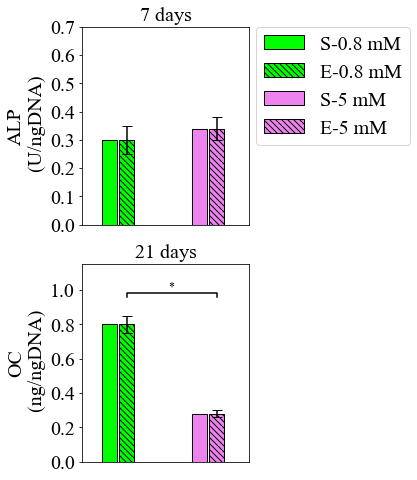

In [5]:
import sys
import pathlib
import os
current_file = '/Users/matin/Downloads/testProjs/MSC_M/scripts'
dir_to_dirs = os.path.join(current_file,'..')
sys.path.insert(0,dir_to_dirs)
from dirs import dir_to_MSC_osteogenesis
sys.path.insert(0,dir_to_MSC_osteogenesis)
from MSC_osteogenesis import *
import importlib
import plots
import observations
importlib.reload(plots)
importlib.reload(observations)
from observations import observations


	##/ run test simultions and plot

with open('/Users/matin/Downloads/testProjs/MSC_M/results/inferred_params.json') as file:
    inferred_params = json.load(file)
obj = MSC_model(fixed_params=fixed_params,free_params = inferred_params)
simulation_results = obj.simulate_studies()
error = obj.run()
for study in observations['studies']:
    if study == 'Qiao_2021_Mg' or study == 'Ber_2016':
        plot_obj = plots.Plot_bar_2(study,observations)
    else:
        plot_obj = plots.Plot_bar(study,observations)
    plot_obj.plot(simulation_results[study])
